## 準備
著者サイトで公開されているデータを使います。

http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html

In [1]:
import requests
import zipfile
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
%precision 3

'%.3f'

In [3]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

### 例題データのダウンロード

In [4]:
# 著者サイトから3ファイル(data4a.csvとdata4b.csv, )をダウンロード
response = requests.get('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/glmm/data.csv')
with open ('data7.csv', 'wb') as f:
    f.write(response.content)
    f.close()

## 7.1 例題：GLMでは説明できないカウントデータ

In [5]:
data = pd.read_csv('data7.csv')

data.head()

,N,y,x,id
0,8,0,2,1
1,8,1,2,2
2,8,2,2,3
3,8,4,2,4
4,8,1,2,5


In [6]:
# 二項分布にしたがうとして、y=β1+β2xの線形予測子とロジットリンク関数でモデルを作成
result = smf.glm(formula='y + I(N-y) ~ x', data=data, family=sm.families.Binomial()).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      ['y', 'I(N - y)']   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -322.80
Date:                Sat, 17 Feb 2018   Deviance:                       513.84
Time:                        15:19:55   Pearson chi2:                     428.
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -2.1487      0.237     -9.057      0.000        -2.614    -1.684
x              0.5104      0.056      9.179      0.000         0.401     0.619
==============================================================================
"""

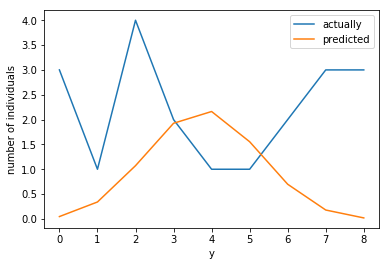

In [7]:
# x=4における種子数分布の予測値と実測値をプロット
from scipy.stats import binom

y = np.arange(9)

logistic = lambda beta1, beta2, x: 1 / (1 + math.exp(-(beta1 + beta2*x)))
q = logistic(result.params['Intercept'], result.params['x'], 4)

plt.plot(y, [len(data[(data['x']==4) & (data['y']==y_i)]) for y_i in y], label='actually')
plt.plot(y, [binom.pmf(y_i, 8, q)*8 for y_i in y], label='predicted')
plt.legend()
plt.xlabel('y')
plt.ylabel('number of individuals')
plt.show()

## 7.2 過分散と個体差

x=4の時のyはかなり分散が大きい。

In [8]:
data4 = data[(data['x']==4)]

print('平均:', data4['y'].mean())
print('分散:', data4['y'].var())

平均: 4.05
分散: 8.365789473684211


## 7.3 一般化線形混合モデル

平均: 4.14
分散: 1.0404
平均: 4.38
分散: 9.7156


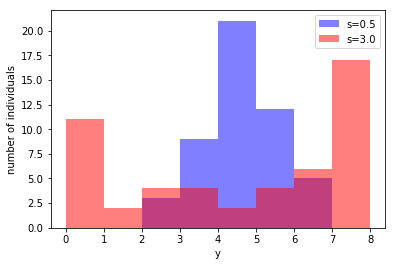

In [9]:
from scipy.stats import binom, norm

# fixedが固定効果、randomがランダム効果の変数
# (fixed=0とすることで、ランダム効果のみで二項分布のパラメータqを計算する)
logistic = lambda fixed, random: 1 / (1 + math.exp(-(fixed + random)))

# 個体差のばらつきが小さい場合(s=0.5)
r_small = norm.rvs(loc=0, scale=0.5, size=50, random_state=0)
q_small = [logistic(0, r_i) for r_i in r_small]
d_small = np.array([binom.rvs(8, q_i, size=1, random_state=0)[0] for q_i in q_small])
plt.hist(d_small, bins=range(9), alpha=0.5, color='blue', label='s=0.5')

print('平均:', d_small.mean()) # 4.14
print('分散:', d_small.var()) # 1.0404

# 個体差のばらつきが大きい場合(s=3.0)
r_large = norm.rvs(loc=0, scale=3.0, size=50, random_state=0)
q_large = [logistic(0, r_i) for r_i in r_large]
d_large = np.array([binom.rvs(8, q_i, size=1, random_state=0)[0] for q_i in q_large])
plt.hist(d_large, bins=range(9), alpha=0.5, color='red', label='s=3.0')

print('平均:', d_large.mean()) # 4.38
print('分散:', d_large.var()) # 9.7156

plt.legend()
plt.xlabel('y')
plt.ylabel('number of individuals')
plt.show()

## 7.4 一般化線形モデルの最尤推定

In [10]:
# 事前にRをインストールしておく必要があります
import pyper # pip install pyper

# Rオブジェクトを取得
r = pyper.R()
type(r)

pyper.R

In [11]:
# assignメソッドでRに名前dataで変数を渡す
r.assign("data", data)

print(r("summary(data)"))

try({summary(data)})
       N           y              x           id        
 Min.   :8   Min.   :0.00   Min.   :2   Min.   :  1.00  
 1st Qu.:8   1st Qu.:1.00   1st Qu.:3   1st Qu.: 25.75  
 Median :8   Median :3.00   Median :4   Median : 50.50  
 Mean   :8   Mean   :3.81   Mean   :4   Mean   : 50.50  
 3rd Qu.:8   3rd Qu.:7.00   3rd Qu.:5   3rd Qu.: 75.25  
 Max.   :8   Max.   :8.00   Max.   :6   Max.   :100.00  



In [12]:
# glmmMLを事前にインストールしておきます
# install.packages("glmmML")

# glmmMLを使って最尤推定
print(r("""
library(glmmML)
result <- glmmML(cbind(y, N-y) ~ x, data = data, family = binomial, cluster = id)
result
"""))

try({
+ library(glmmML)
+ result <- glmmML(cbind(y, N-y) ~ x, data = data, family = binomial, cluster = id)
+ result
+ })

Call:  glmmML(formula = cbind(y, N - y) ~ x, family = binomial, data = data,      cluster = id) 


              coef se(coef)      z Pr(>|z|)
(Intercept) -4.190   0.8777 -4.774 1.81e-06
x            1.005   0.2075  4.843 1.28e-06

Scale parameter in mixing distribution:  2.408 gaussian 
Std. Error:                              0.2202 

        LR p-value for H_0: sigma = 0:  2.136e-55 

Residual deviance: 269.4 on 97 degrees of freedom 	AIC: 275.4 



In [13]:
# result変数をgetメソッドでPythonオブジェクト(dict)として取得
result = r.get("result")

result

{'aic': 275.414,
 'boot': 0,
 'bootP': None,
 'call': array(['glmmML', 'cbind(y, N - y) ~ x', 'binomial', 'data', 'id'],
       dtype='<U19'),
 'cluster.null.deviance': 513.836,
 'cluster.null.df': 98,
 'coef.sd': array([ 0.878,  0.207]),
 'coefficients': array([-4.19 ,  1.005]),
 'converged': True,
 'deviance': 269.414,
 'df.residual': 97,
 'info': 0,
 'posterior.modes': array([-1.337,  0.195,  0.967,  2.007,  0.195, -1.337, -1.337,  3.556,
         0.195,  2.962, -1.337, -1.337, -1.337, -1.337, -1.337,  0.195,
         1.526,  2.469,  1.526,  3.556,  0.069, -0.648, -1.951,  2.05 ,
        -0.648,  0.069, -1.951, -1.951, -1.951,  0.608,  1.546,  1.546,
        -1.951, -1.951, -1.951,  3.639,  1.082,  0.069, -1.951,  3.639,
         1.142, -0.834, -2.638,  0.624,  1.142, -0.834,  2.884, -0.834,
         1.801,  1.801,  2.884, -2.638,  0.157,  1.801, -0.312, -1.507,
        -0.312, -0.834,  2.884, -2.638,  0.938, -0.768, -1.742, -1.233,
        -1.233,  0.938,  2.177,  0.938, -3.378,  0